<a href="https://colab.research.google.com/github/Suryansh1089/SUMMERPROJECT2021/blob/main/Sarcasm_Glove_twitter_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [4]:
data=pd.read_json("twitter_train.jsonl",lines=True)

In [5]:
data.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


In [9]:
data.tail()

,label,response,context
4995,NOT_SARCASM,@USER You don't . I have purchased a lot on Am...,[@USER Apologies for the inconvenience you fac...
4996,NOT_SARCASM,@USER #Emotions you say 🤔 never knew that I th...,"[@USER 🤔 idk tho , I think I ’ m #hungry . But..."
4997,NOT_SARCASM,"@USER @USER @USER You are so right ... "" Yes !...","[@USER @USER @USER Peace to you , and two coun..."
4998,NOT_SARCASM,@USER @USER @USER Another lazy delusional vote...,[Bernie Sanders told Elizabeth Warren in priva...
4999,NOT_SARCASM,@USER @USER I hope you know no news outlet fro...,[PDP PROTEST BRAINSTORMING SESSION Deji : We n...


In [6]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["response"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[['get',
  'obviously',
  'care',
  'would',
  'moved',
  'right',
  'along',
  'instead',
  'decided',
  'care',
  'troll'],
 ['trying', 'protest', 'talking', 'labels', 'label', 'wtf', 'make', 'em'],
 ['makes', 'insane', 'money', 'movies', 'einstein', 'learnhowthesystemworks'],
 ['meanwhile',
  'trump',
  'even',
  'release',
  'sat',
  'scores',
  'wharton',
  'professors',
  'said',
  'dumbest',
  'student',
  'ever',
  'taught'],
 ['pretty',
  'sure',
  'antilincoln',
  'crowd',
  'claimed',
  'democracy',
  'ballot',
  'thought',
  'lincoln',
  'authoritarian',
  'gop',
  'partyoflincoln',
  'democrats'],
 ['per', 'tag', 'line', 'never', 'judge', 'book', 'cover'],
 ['excites', 'kill', 'millions'],
 ['oh',
  'look',
  'racist',
  'offering',
  'solidarity',
  'gullible',
  'idiot',
  'whining',
  'racists'],
 ['biggest', 'bullies'],
 ['responds',
  'facts',
  'tossing',
  'frantic',
  'insults',
  'accuses',
  'others',
  'triggered',
  'facts']]

In [10]:
def trans(x):
  if x=='SARCASM':
    return 1
  if x=='NOT_SARCASM':
    return 0

In [13]:
data['label']=data['label'].apply(trans)

In [15]:
data.tail()

,label,response,context
4995,0,@USER You don't . I have purchased a lot on Am...,[@USER Apologies for the inconvenience you fac...
4996,0,@USER #Emotions you say 🤔 never knew that I th...,"[@USER 🤔 idk tho , I think I ’ m #hungry . But..."
4997,0,"@USER @USER @USER You are so right ... "" Yes !...","[@USER @USER @USER Peace to you , and two coun..."
4998,0,@USER @USER @USER Another lazy delusional vote...,[Bernie Sanders told Elizabeth Warren in priva...
4999,0,@USER @USER I hope you know no news outlet fro...,[PDP PROTEST BRAINSTORMING SESSION Deji : We n...


(-0.5, 999.5, 499.5, -0.5)

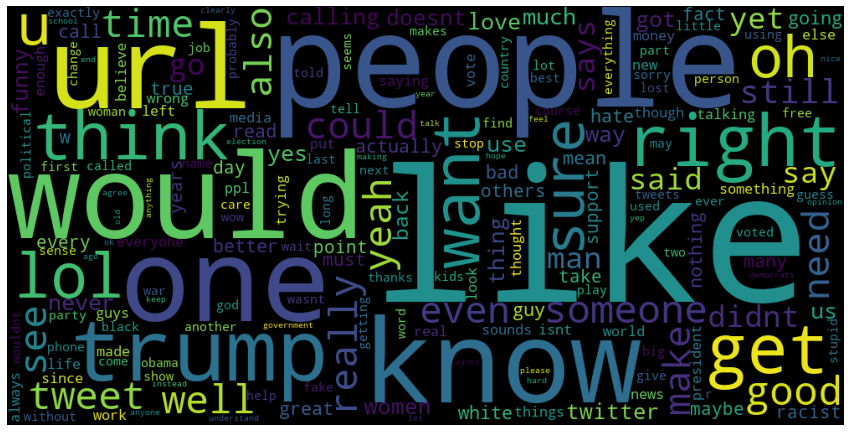

In [16]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['label'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [17]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['label'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  12450
vocab size - 12451


In [18]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (4000, 25)
Shape of y_train: (4000,)
Shape of X_test_pad: (1000, 25)
Shape of y_test: (1000,)


LOAD GLOVE MODEL


In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-07-05 15:36:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-05 15:36:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-05 15:36:04--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
%ls

glove.6B.100d.txt  glove.6B.50d.txt  Sarcasm_Headlines_Dataset.json
glove.6B.200d.txt  glove.6B.zip
glove.6B.300d.txt  sample_data/


In [ ]:
embeddings_index = {}
embedding_dim = 100
f = open("/content/glove.6B.100d.txt", encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


BUILDING THE EMBEDDING LAYER

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24011


In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

BUILD THE RNN

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           2748400   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,790,705
Trainable params: 42,305
Non-trainable params: 2,748,400
_________________________________________________________________
None


TRAINING

In [ ]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/25
668/668 - 77s - loss: 0.5660 - acc: 0.7082 - val_loss: 0.5144 - val_acc: 0.7469
Epoch 2/25
668/668 - 54s - loss: 0.4931 - acc: 0.7650 - val_loss: 0.4578 - val_acc: 0.7839
Epoch 3/25
668/668 - 53s - loss: 0.4539 - acc: 0.7868 - val_loss: 0.4349 - val_acc: 0.7978
Epoch 4/25
668/668 - 53s - loss: 0.4318 - acc: 0.7984 - val_loss: 0.4156 - val_acc: 0.8118
Epoch 5/25
668/668 - 53s - loss: 0.4097 - acc: 0.8140 - val_loss: 0.4098 - val_acc: 0.8087
Epoch 6/25
668/668 - 53s - loss: 0.3877 - acc: 0.8240 - val_loss: 0.4082 - val_acc: 0.8148
Epoch 7/25
668/668 - 55s - loss: 0.3741 - acc: 0.8324 - val_loss: 0.4009 - val_acc: 0.8122
Epoch 8/25
668/668 - 53s - loss: 0.3602 - acc: 0.8414 - val_loss: 0.4075 - val_acc: 0.8210
Epoch 9/25
668/668 - 53s - loss: 0.3462 - acc: 0.8473 - val_loss: 0.4017 - val_acc: 0.8139
Epoch 10/25
668/668 - 53s - loss: 0.3383 - acc: 0.8522 - val_loss: 0.4137 - val_acc: 0.8193
Epoch 11/25
668/668 - 53s - loss: 0.3234 - acc: 0.8597 - val_loss: 0.3989 - val_acc: 0.81

Visualize the learning

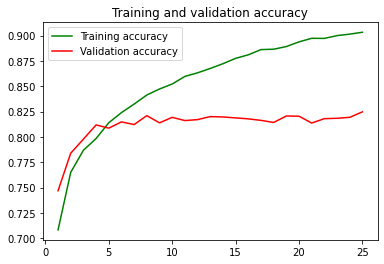

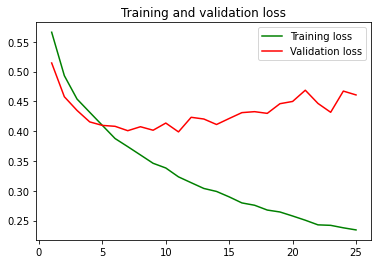

In [ ]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

PREDICTING FORM

In [ ]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"response":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

In [1]:
predict_sarcasm("You are genius.")

NameError: ignored